In [1]:
# Imports
#from datetime import datetime
import datetime as dt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
#import plotly
import  chart_studio
import plotly.graph_objs as go
import plotly as py
import plotly.tools as tls
import plotly.figure_factory as ff

#plotly.__version__

In [79]:
# List of Datafiles
print(os.listdir("./data"))

['circuits.csv', 'status.csv', 'drivers.csv', 'driverStandings.csv', 'races.csv', 'constructors.csv', 'constructorResults.csv', 'driver.csv', 'lapTimes.csv', 'qualifying.csv', 'result.csv', 'pitStops.csv', '.ipynb_checkpoints', 'seasons.csv', 'constructorStandings.csv', 'results.csv']


In [80]:
pitstops = pd.read_csv('./data/pitStops.csv')
results = pd.read_csv('./data/results.csv')
races = pd.read_csv('./data/races.csv')
circuits = pd.read_csv('./data/circuits.csv', encoding='latin1')
drivers = pd.read_csv('./data/drivers.csv', encoding='latin1')

#identify yellow flag
laptimes = pd.read_csv('./data/lapTimes.csv')
laptimes.head()

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [81]:
races.tail()

,raceId,year,round,circuitId,name,date,time,url
992,1005,2018,17,22,Japanese Grand Prix,2018-10-07,05:00:00,http://en.wikipedia.org/wiki/2018_Japanese_Gra...
993,1006,2018,18,69,United States Grand Prix,2018-10-21,19:00:00,http://en.wikipedia.org/wiki/2018_United_State...
994,1007,2018,19,32,Mexican Grand Prix,2018-10-28,19:00:00,http://en.wikipedia.org/wiki/2018_Mexican_Gran...
995,1008,2018,20,18,Brazilian Grand Prix,2018-11-11,16:00:00,http://en.wikipedia.org/wiki/2018_Brazilian_Gr...
996,1009,2018,21,24,Abu Dhabi Grand Prix,2018-11-25,13:00:00,http://en.wikipedia.org/wiki/2018_Abu_Dhabi_Gr...


In [4]:
# Time Behind Leader
laptimes.sort_values(by = ['raceId', 'driverId', 'lap'], inplace=True)

laptimes.head()
#calculating the "totalmilliseconds" and creating apropriate column for it in the df
laptimes['totalmilli'] = laptimes.groupby(['raceId', 'driverId'])['milliseconds'].transform(pd.Series.cumsum)

In [50]:
laptimes.tail()

,raceId,driverId,lap,position,time,milliseconds,totalmilli,position_plus_1,totalmilli_plus_1,position_min_1,totalmilli_min_1,to_in_front,to_behind
426628,988,843,50,15,1:44.204,104204,5314961,15.0,5312792.0,15.0,5317038.0,2169.0,2077.0
426629,988,843,51,15,1:44.171,104171,5419132,15.0,5416938.0,15.0,5421302.0,2194.0,2170.0
426630,988,843,52,15,1:43.897,103897,5523029,15.0,5520857.0,15.0,5525637.0,2172.0,2608.0
426631,988,843,53,15,1:44.249,104249,5627278,15.0,5625121.0,15.0,5629648.0,2157.0,2370.0
426632,988,843,54,15,1:44.741,104741,5732019,15.0,5729891.0,15.0,5733961.0,2128.0,1942.0


In [6]:
laptimes_2 = laptimes[['raceId', 'lap', 'position', 'totalmilli']].copy()
laptimes_3 = laptimes[['raceId', 'lap', 'position', 'totalmilli']].copy()

# Adding and subtracting "1" to each position, so that we can merge the "correct" position with the one in front of it:
laptimes_2['position'] = laptimes_2['position'] + 1
laptimes_2.rename(columns={'position': "position_plus_1", 'totalmilli' : 'totalmilli_plus_1'}, inplace=True)

laptimes_3['position'] = laptimes_3['position'] -1
laptimes_3.rename(columns={'position': "position_min_1", 'totalmilli' : 'totalmilli_min_1'}, inplace=True)

# Mearging two dataframes:
merged = pd.merge(laptimes, laptimes_2, how = 'left', left_on=['raceId', 'lap', 'position'],
                  right_on=['raceId', 'lap', 'position_plus_1'])

# Mearging two dataframes:
merged = pd.merge(merged, laptimes_3, how = 'left', left_on=['raceId', 'lap', 'position'],
                  right_on=['raceId', 'lap', 'position_min_1'])

# Calculating how far each car behind/in front:
merged['to_in_front'] = merged['totalmilli'] - merged['totalmilli_plus_1']
merged['to_behind'] = merged['totalmilli_min_1'] - merged['totalmilli']

In [54]:
merged.head(23)

,raceId,driverId,lap,position,time,milliseconds,totalmilli,position_plus_1,totalmilli_plus_1,position_min_1,totalmilli_min_1,to_in_front,to_behind
0,1,1,1,13,1:49.088,109088,109088,13.0,108449.0,13.0,109367.0,639.0,279.0
1,1,1,2,12,1:33.740,93740,202828,12.0,201778.0,12.0,203287.0,1050.0,459.0
2,1,1,3,11,1:31.600,91600,294428,11.0,294209.0,11.0,295507.0,219.0,1079.0
3,1,1,4,10,1:31.067,91067,385495,10.0,385066.0,10.0,387274.0,429.0,1779.0
4,1,1,5,10,1:32.129,92129,477624,10.0,477193.0,10.0,478623.0,431.0,999.0
5,1,1,6,9,1:30.469,90469,568093,9.0,561344.0,9.0,569093.0,6749.0,1000.0
6,1,1,7,9,1:29.488,89488,657581,9.0,651401.0,9.0,660214.0,6180.0,2633.0
7,1,1,8,9,1:30.302,90302,747883,9.0,741574.0,9.0,751215.0,6309.0,3332.0
8,1,1,9,9,1:30.889,90889,838772,9.0,832539.0,9.0,842343.0,6233.0,3571.0
9,1,1,10,8,1:32.418,92418,931190,8.0,924852.0,8.0,933694.0,6338.0,2504.0


In [7]:
#Checking Results of Time Between
# 'to_previous' has to be >= 0:
print("positive:", merged[merged['to_in_front']>0].shape)
print("equal zero:", merged[merged['to_in_front']==0].shape)
print('less than zero', merged[merged['to_in_front']<0].shape)

positive: (402354, 13)
equal zero: (5, 13)
less than zero (1, 13)


In [55]:
# Now we can delete 'position_plus_1' and 'totalmilli_plus_1' columns if needed.
merged.drop(['position_plus_1', 'totalmilli_plus_1', 'position_min_1', 'totalmilli_min_1'], axis=1, inplace = True)
# Puting merged df into laptimes
laptimes = merged.copy()
laptimes.head()

,raceId,driverId,lap,position,time,milliseconds,totalmilli,to_in_front,to_behind
0,1,1,1,13,1:49.088,109088,109088,639.0,279.0
1,1,1,2,12,1:33.740,93740,202828,1050.0,459.0
2,1,1,3,11,1:31.600,91600,294428,219.0,1079.0
3,1,1,4,10,1:31.067,91067,385495,429.0,1779.0
4,1,1,5,10,1:32.129,92129,477624,431.0,999.0


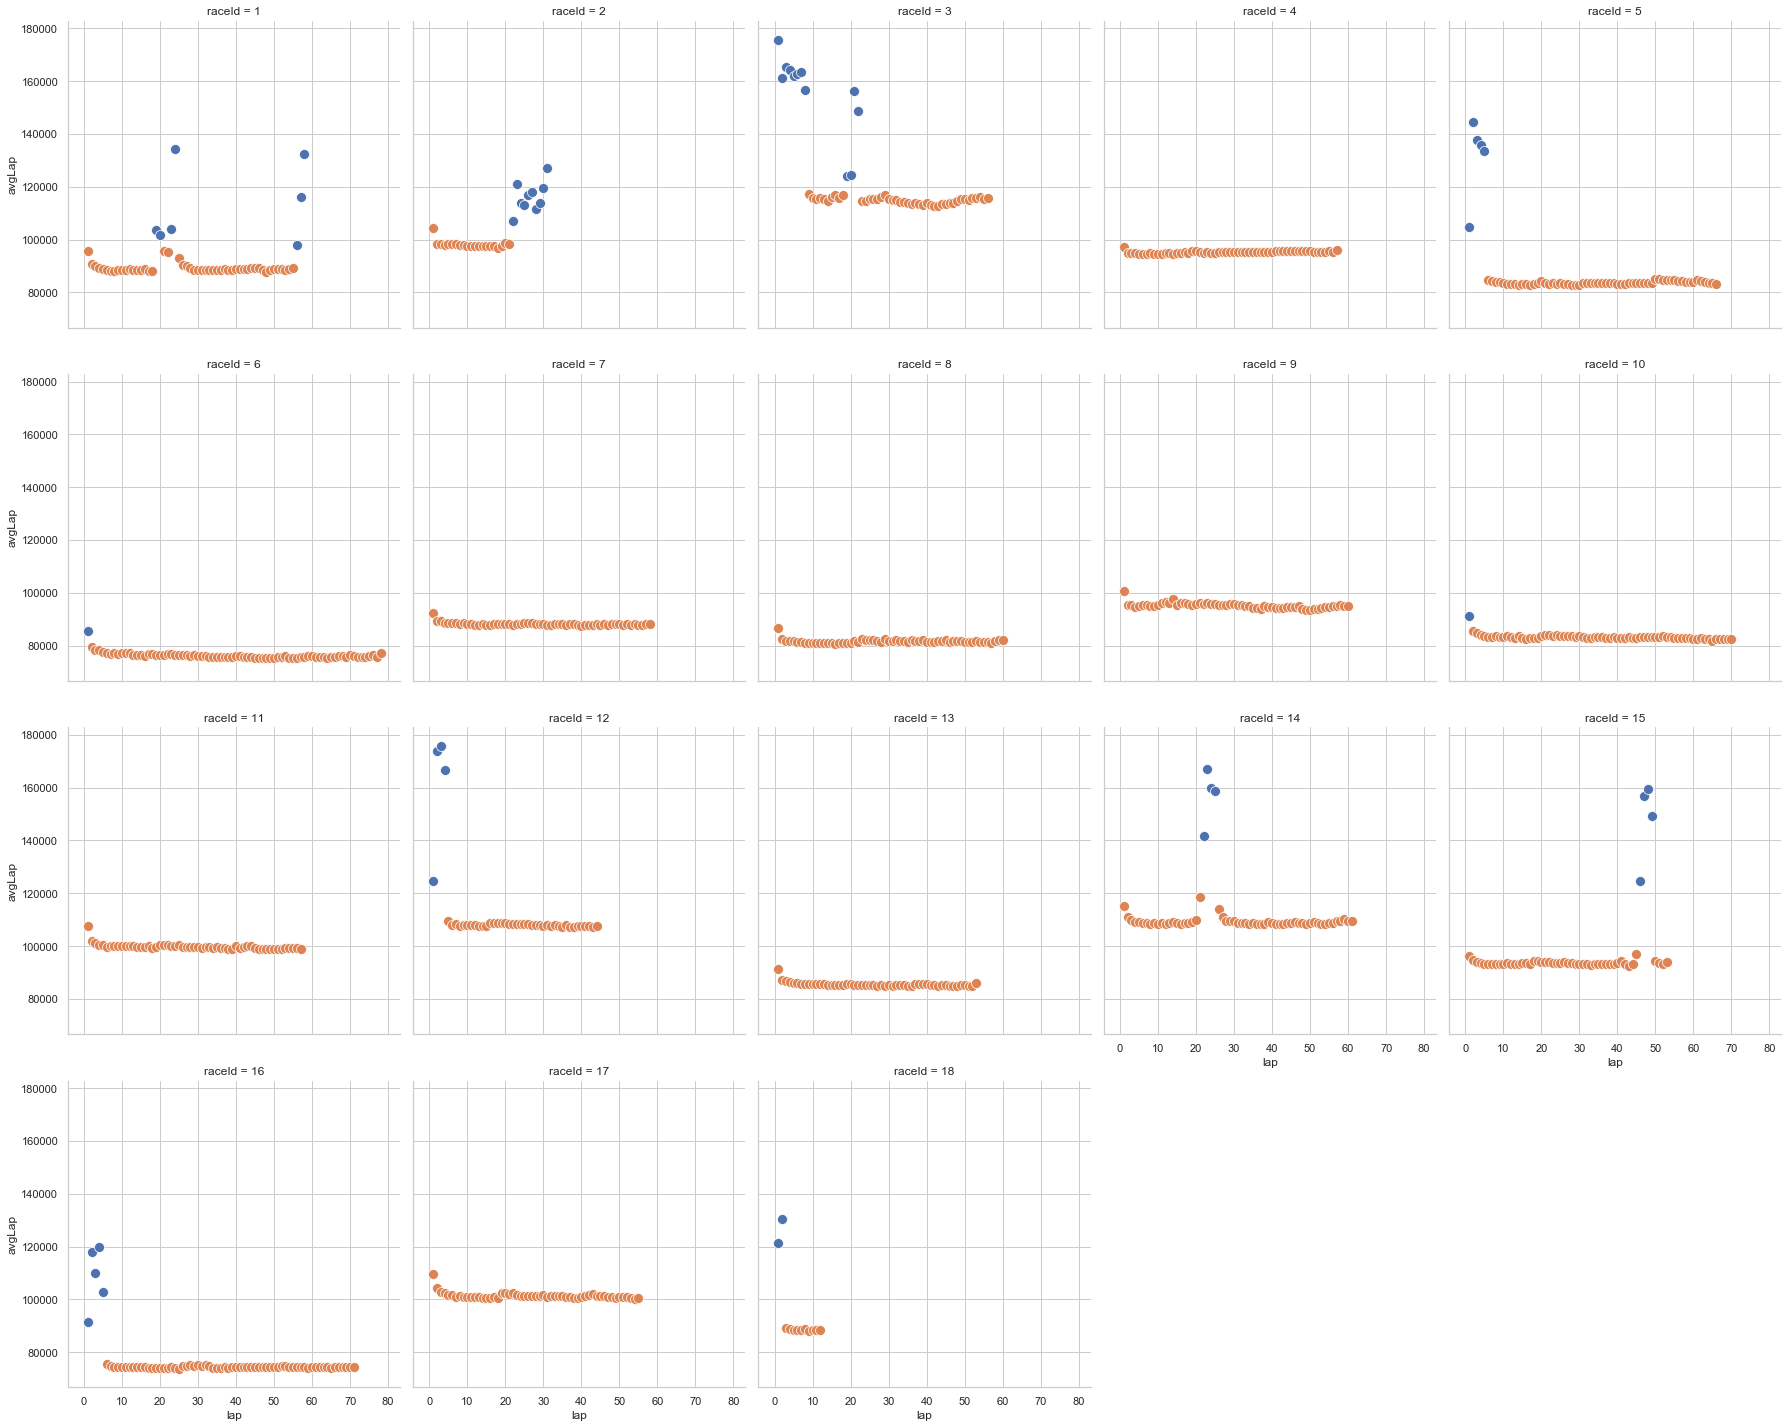

In [78]:
leaders = results.loc[results['positionOrder']<=10][['raceId','driverId']]
leaders.head(100)

winLaps = laptimes.merge(leaders, on=['raceId','driverId'])

avgLaps = winLaps.groupby(['raceId', 'lap'])['milliseconds'].min().reset_index()
avgLaps.head()

BestLapSpeed = avgLaps.groupby(['raceId'])['milliseconds'].min().reset_index()
BestLapSpeed.head()

#WorstLapSpeed = avgLaps.groupby(['raceId'])['milliseconds'].max().reset_index()
#WorstLapSpeed = WorstLapSpeed.rename(index=str, columns={"milliseconds": "slow"})
#WorstLapSpeed.head()

#BestLapSpeed = BestLapSpeed.merge(WorstLapSpeed, on='raceId')
#BestLapSpeed['yellowThreshold'] = (BestLapSpeed['milliseconds'] + BestLapSpeed['slow'] )/2 
BestLapSpeed['yellowThreshold'] = (BestLapSpeed['milliseconds'] * 1.1) #+ BestLapSpeed['slow'] )/2 
BestLapSpeed.head()

avgLaps = avgLaps.merge(BestLapSpeed[['raceId','yellowThreshold']], on='raceId')
avgLaps['flag'] = (avgLaps['yellowThreshold'] >  avgLaps['milliseconds']).astype(int)

avgLaps = avgLaps.rename(index=str, columns={"milliseconds": "avgLap"})

avgLaps.head()

sns.set(style="whitegrid")
#sns.set(rc={'figure.figsize':(6,7)})
g = sns.FacetGrid(avgLaps.head(1000), col="raceId", aspect=1 ,col_wrap=5, height=5, hue='flag')
g = g.map(sns.scatterplot, "lap", "avgLap", s=100)

#g = g.map(sns.scatterplot, "year", "lap", s=150)
#g = g.map(sns.violinplot, 'year','lap',hue="positionText" )
#ax = sns.violinplot(x="year", y="lap",  data=main, height = 50)

#sns.scatterplot(data=winners.loc[winners['raceId']==21].loc[winners['pit']==1],  x="lap", y="milliseconds_y", s=550,hue = 'pit')
#sns.scatterplot(data=winners.loc[winners['raceId']==960].loc[winners['pit']==1],  x="lap", y="milliseconds_y", s=100,hue = 'pit')
#sns.scatterplot(data=winners.loc[winners['raceId']==962],  x="lap", y="milliseconds_y", s=100,hue = 'pit')

In [58]:
laptimes2 = laptimes.merge(avgLaps, on=['raceId','lap']).reset_index()
laptimes2.head()


#winners['fastmillis'] = pd.to_datetime(winners['fastestLapTime'])
#winners.head()

#avgLaps = avgLaps.merge(winners[['raceId','fastestLapTime']], on=['raceId'])
#avgLaps.head()
winners = results.loc[results['positionOrder']<10]
winners.head()

winners = winners.merge(laptimes2, on=['raceId','driverId'])
winners.head()

winners = winners.merge(pitstops,how='outer', on =['raceId','driverId','lap'])
winners.head()
winners.loc[winners['duration'].notnull()].head()

winners['pit'] = winners['duration'].notnull().astype(int) 
winners['milliseconds'].fillna(0, inplace=True) 

winners['lap_millis'] = winners['milliseconds_y'] -  winners['milliseconds']


winners = winners.loc[winners['raceId']==952] #950
winners.loc[winners['pit']==1].head()
winners.loc[winners['flag']==0].head()

,resultId,raceId,driverId,constructorId,number,grid,position_x,positionText,positionOrder,points,...,to_behind,avgLap,yellowThreshold,flag,stop,time,duration,milliseconds,pit,lap_millis
196869,23005.0,952,830,9.0,33.0,4.0,1.0,1,1.0,25.0,...,1083.0,113669.0,96771.4,0.0,NaN,NaN,NaN,0.0,0,114582.0
196870,23005.0,952,830,9.0,33.0,4.0,1.0,1,1.0,25.0,...,772.0,130759.0,96771.4,0.0,NaN,NaN,NaN,0.0,0,133185.0
196871,23005.0,952,830,9.0,33.0,4.0,1.0,1,1.0,25.0,...,717.0,120671.0,96771.4,0.0,NaN,NaN,NaN,0.0,0,127131.0
196935,23006.0,952,8,6.0,7.0,5.0,2.0,2,2.0,18.0,...,806.0,113669.0,96771.4,0.0,NaN,NaN,NaN,0.0,0,118161.0
196936,23006.0,952,8,6.0,7.0,5.0,2.0,2,2.0,18.0,...,632.0,130759.0,96771.4,0.0,NaN,NaN,NaN,0.0,0,132481.0


In [59]:
leader = winners.loc[winners['position_y']==1]
leader.head()
leader = leader.rename(index=str, columns={"totalmilli": "lead_milli"})
winners = winners.merge(leader[['lap','lead_milli']], on='lap')
winners[['totalmilli','lead_milli']].head()

winners['behind'] = (winners['totalmilli'] -winners['lead_milli'])  #.astype(dt.timedelta)
winners[['behind','totalmilli','lead_milli']].head()
winners.head()

,resultId,raceId,driverId,constructorId,number,grid,position_x,positionText,positionOrder,points,...,yellowThreshold,flag,stop,time,duration,milliseconds,pit,lap_millis,lead_milli,behind
0,23005.0,952,830,9.0,33.0,4.0,1.0,1,1.0,25.0,...,96771.4,0.0,NaN,NaN,NaN,0.0,0,114582.0,113669.0,913.0
1,23006.0,952,8,6.0,7.0,5.0,2.0,2,2.0,18.0,...,96771.4,0.0,NaN,NaN,NaN,0.0,0,118161.0,113669.0,4492.0
2,23007.0,952,20,6.0,5.0,6.0,3.0,3,3.0,15.0,...,96771.4,0.0,NaN,NaN,NaN,0.0,0,116984.0,113669.0,3315.0
3,23008.0,952,817,9.0,3.0,3.0,4.0,4,4.0,12.0,...,96771.4,0.0,NaN,NaN,NaN,0.0,0,113669.0,113669.0,0.0
4,23009.0,952,822,3.0,77.0,7.0,5.0,5,5.0,10.0,...,96771.4,0.0,NaN,NaN,NaN,0.0,0,118967.0,113669.0,5298.0


Text(0, 0.5, 'y2Label')

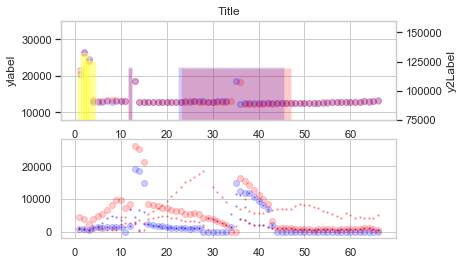

In [60]:
# Let's build our plot
import matplotlib.pyplot as plt
%matplotlib inline
# needed for jupyter notebooks
    
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax3 = fig.add_subplot(212)

#fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # set up the 2nd axis

car = winners.loc[winners['positionOrder']==1]
color = 'blue'

ret = ax1.bar(data=car.loc[car['pit']==1], x="lap", height="milliseconds", width=1, alpha=0.2, color=color) #plot the Revenue on axis #1
# the next few lines plot the fiscal year data as bar plots and changes the color for each.
#ax2.bar(data=car,  x="lap", height="milliseconds_y",width=2, alpha=0.2, color='blue')
ax2.scatter(data=car, x='lap', y = 'lap_millis',color=color, alpha=0.2)
ax3.scatter(x='lap', y = 'behind', data=car,color=color, alpha=0.2)
ax3.scatter(x='lap', y = 'to_in_front',s=2, data=car, color=color, alpha=0.3)
ax3.scatter(x='lap', y = 'to_behind',s=2, data=car, color=color, alpha=0.3)

car = winners.loc[winners['positionOrder']==2]
color = 'red'

ret = ax1.bar(data=car.loc[car['pit']==1], x="lap", height="milliseconds", width=1, alpha=0.2, color=color) #plot the Revenue on axis #1
# the next few lines plot the fiscal year data as bar plots and changes the color for each.
#ax2.bar(data=car,  x="lap", height="milliseconds_y",width=2, alpha=0.2, color='blue')
ax2.scatter(data=car, x='lap', y = 'lap_millis',color=color, alpha=0.2)
ax3.scatter(x='lap', y = 'behind', data=car,color=color, alpha=0.2)
ax3.scatter(x='lap', y = 'to_in_front',s=2, data=car, color=color, alpha=0.3)
ax3.scatter(x='lap', y = 'to_behind',s=2, data=car, color=color, alpha=0.3)


ret = ax2.bar(data=car.loc[car['flag']==0], x="lap", height='milliseconds_y', width=1, alpha=0.4, color='yellow') #plot the Revenue on axis #1


ax2.grid(b=False) # turn off grid #2
ax1.set_ylim(8000,35000)
ax2.set_ylim(75000,160000)

ax1.set_title('Title')
ax1.set_ylabel('ylabel')
ax2.set_ylabel('y2Label')
 
#ax3.plot(data=car, x='lap', y = 'position_y',color='red', alpha=0.2)
    
# Set the x-axis labels to be more meaningful than just some random dates.
#labels = ['FY 2010', 'FY 2011','FY 2012', 'FY 2013','FY 2014', 'FY 2015']
#ax1.axes.set_xticklabels(labels);

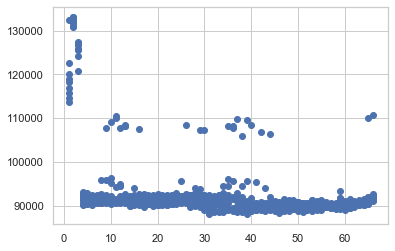

In [61]:
winners['hue'] = winners['position_y'] #/4 
import pylab as plt


plt.scatter(data=winners, x='lap', y = 'milliseconds_y')
#plt.scatter(X,Y2,color='g')
plt.show()

In [65]:
main = results.copy()
race_circuit = races[['raceId','circuitId','year']]
main = main.merge(race_circuit, on='raceId')
main = main.merge(pitstops, on=['raceId','driverId'])

main = main.merge(avgLaps, on=['raceId','lap']).reset_index()
main.head()

#main = main.merge(laptimes2, on=['raceId','driverId'])
#winners.head()

main = main.loc[main['positionOrder'] < 8]
main = main.loc[main['year'] > 2013]
main = main.loc[main['circuitId'] == 4]
main = main.loc[main['milliseconds_y'] < 60000 * 10]
#main.head()
main['x'] = main['year'] + (main['position']/10)
#main['pitflag'] = main['pit'] + (main['flag']*2)

main = main[['positionText','position','circuitId','lap','year','milliseconds_y','x','flag']]
#main = main.loc[main['positionText'] > 0]
main = main[main.positionText.apply(lambda x: x.isnumeric())]
main.tail(23)

,positionText,position,circuitId,lap,year,milliseconds_y,x,flag
4769,3,3.0,4,37,2016,21603,2016.3,1
4771,4,4.0,4,11,2016,21738,2016.4,1
4775,4,4.0,4,28,2016,22104,2016.4,1
4776,4,4.0,4,43,2016,21683,2016.4,1
4777,4,4.0,4,65,2016,23133,2016.4,1
4778,5,5.0,4,39,2016,22443,2016.5,1
4780,6,6.0,4,10,2016,22874,2016.6,1
4784,6,6.0,4,38,2016,22937,2016.6,1
4785,7,7.0,4,9,2016,22679,2016.7,1
5710,1,1.0,4,21,2017,21544,2017.1,1


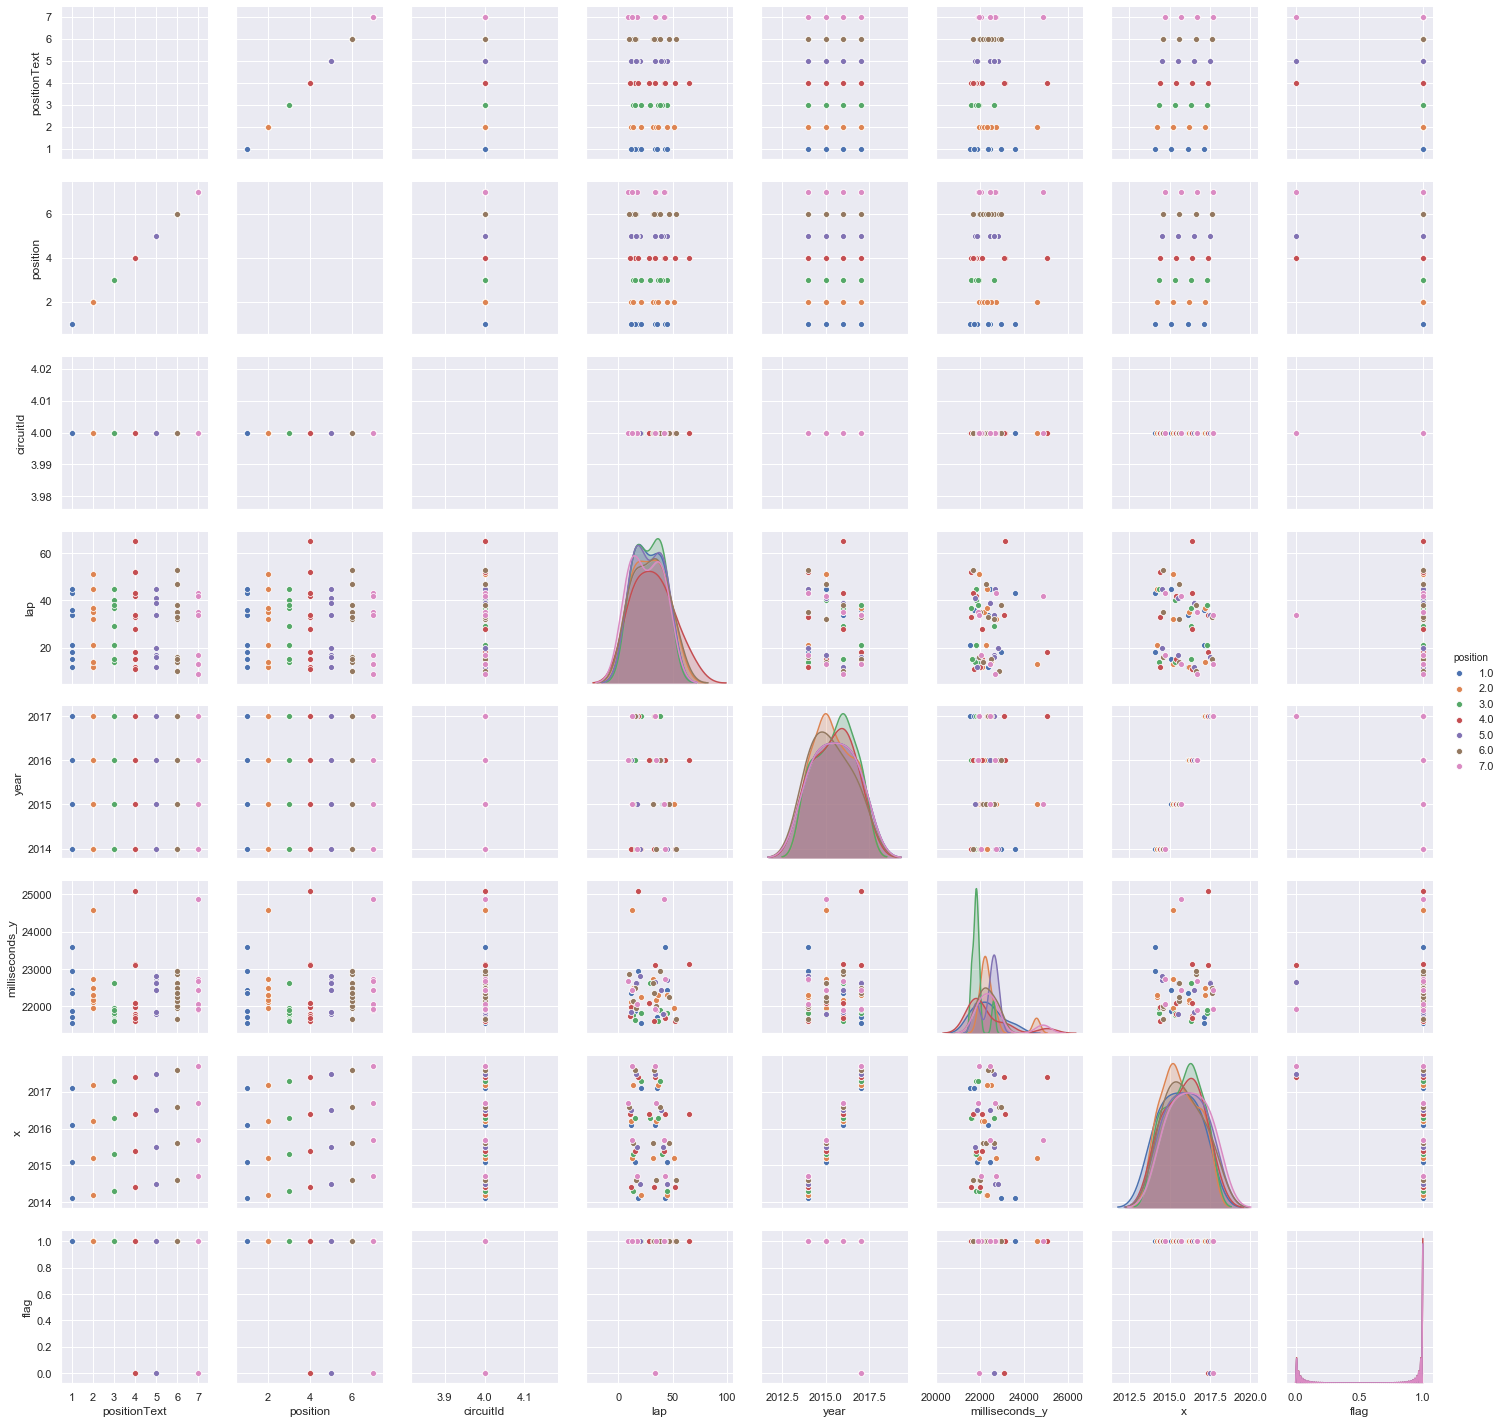

In [66]:

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(6,7)})
#g = sns.FacetGrid(winners.head(1000), col="raceId", aspect=1 ,col_wrap=5, height=5, hue='pit')
#g = g.map(sns.scatterplot, "lap", "milliseconds_y", s=100)

#g = g.map(sns.scatterplot, "year", "lap", s=150)
#g = g.map(sns.violinplot, 'year','lap',hue="positionText" )
#ax = sns.violinplot(x="year", y="lap",  data=main, height = 50)

#sns.scatterplot(data=winners.loc[winners['raceId']==21].loc[winners['pit']==1],  x="lap", y="milliseconds_y", s=550,hue = 'pit');
#sns.scatterplot(data=winners.loc[winners['raceId']==960].loc[winners['pit']==1],  x="lap", y="milliseconds_y", s=100,hue = 'pit')
#ret = sns.scatterplot(data=winners.loc[winners['raceId']==964],  x="lap", y="milliseconds_y",style='position_x', s=100,hue = 'hue')

#sns.scatterplot(data=winners.loc[winners['pit']==1],  x="raceId", y="lap", s=100,hue = 'pit')


#palette="Set2"

sns.pairplot(main, hue="position")

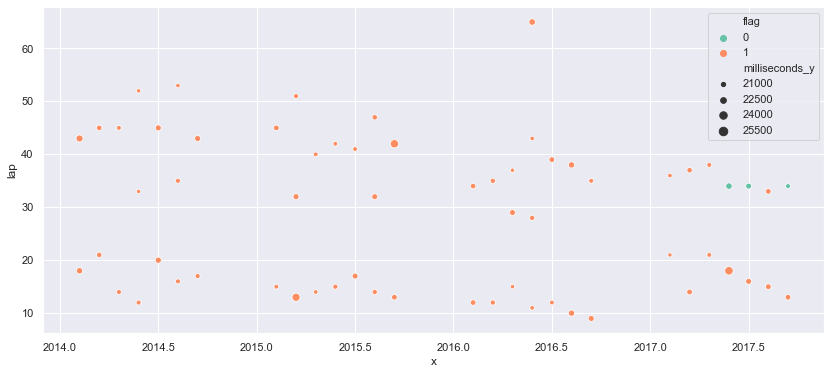

In [67]:
#sns.set(style="ticks")
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(14,6)})
#g = sns.FacetGrid(main, col="year", aspect=0.3 ,col_wrap=5, height=5, hue="positionText")
#g = g.map(sns.scatterplot,  "positionText", "lap", s=150, size='milliseconds_y')

#g = g.map(sns.scatterplot, "year", "lap", s=150)
#g = g.map(sns.violinplot, 'year','lap',hue="positionText" )
#ax = sns.violinplot(x="year", y="lap",  data=main, height = 50)

plt = sns.scatterplot(data=main,  x="x", y="lap", s=550,palette="Set2",hue = 'flag', size = 'milliseconds_y')

#sns.pairplot(main, hue="position")